# Hierarchical Leiden clustering analysis of the HPA subcellular single-cell embeddings

Author: Konstantin Kahnert  
Date: 2024_12_03  
  
This notebook can be used to reproduce the results of the hierarchical Leiden clustering analysis (Figure 7) from the paper:  
  
SubCell: Vision foundation models for microscopy capture single-cell biology. Ankit Gupta, Zoe Wefers, Konstantin Kahnert, Jan N Hansen, William D. Leineweber, Anthony Cesnik, Dan Lu, Ulrika Axelsson, Frederic Ballllosera Navarro, Theofanis Karaletsos, Emma Lundberg. bioRxiv 2024.12.06.627299; doi: https://doi.org/10.1101/2024.12.06.627299.



## Load packages

In [1]:
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
from anndata import AnnData
from gprofiler import GProfiler
from matplotlib.collections import PathCollection

# Suppress all warnings
warnings.filterwarnings("ignore")

# set rcParams to save text as text objects in SVGs
plt.rcParams["svg.fonttype"] = "none"

## Load data

We start by loading the normalized HPA embedding of the MAE-CellS-ProtS-Pool version of the SubCell. The embedding was created using the processed HPA v23 subcellular dataset: 
 
 https://virtualcellmodels.cziscience.com/dataset/01933229-3c87-7818-be80-d7e5578bb0b7  
   
and subsequently normalized for the microscope used (image_width column) and the plate ID number (if_plate_id column) using the PyTorch implementation of Harmony (https://github.com/lilab-bcb/harmony-pytorch).

In [2]:
adata_harm = sc.read_h5ad("HPA_embedding_harmonized_microscope_plateID.h5ad")
adata_harm

AnnData object with n_obs × n_vars = 1138378 × 1536
    obs: 'cell_id', 'if_plate_id', 'position', 'sample', 'atlas_name', 'antibody', 'ensembl_ids', 'gene_names', 'locations', 'cell_path', 'Time (ms)', 'basename', 'image_width', 'well_id', 'well_id_num', 'gene_reliability', 'reliability_rank'

In [3]:
# subset to U2OS cells
adata_harm = adata_harm[adata_harm.obs["atlas_name"] == "U2OS"]
adata_harm.obs

,cell_id,if_plate_id,position,sample,atlas_name,antibody,ensembl_ids,gene_names,locations,cell_path,Time (ms),basename,image_width,well_id,well_id_num,gene_reliability,reliability_rank
0,1,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1,M1,1_A1,19918,Supported,2
1,2,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1,M1,1_A1,19918,Supported,2
2,3,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1,M1,1_A1,19918,Supported,2
3,4,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1,M1,1_A1,19918,Supported,2
4,5,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1,M1,1_A1,19918,Supported,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137779,16,996,H9,2,U2OS,HPA041275,ENSG00000135316,SYNCRIP,"Cytosol,Nucleoplasm",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.417840,996_H9_2,M2,996_H9,42415,Approved,3
1137780,17,996,H9,2,U2OS,HPA041275,ENSG00000135316,SYNCRIP,"Cytosol,Nucleoplasm",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.417840,996_H9_2,M2,996_H9,42415,Approved,3
1137781,18,996,H9,2,U2OS,HPA041275,ENSG00000135316,SYNCRIP,"Cytosol,Nucleoplasm",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.417840,996_H9_2,M2,996_H9,42415,Approved,3
1137782,19,996,H9,2,U2OS,HPA041275,ENSG00000135316,SYNCRIP,"Cytosol,Nucleoplasm",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.417840,996_H9_2,M2,996_H9,42415,Approved,3


## Aggregate single cell embeddings to average protein level emebeddings

For this, we filter out antibodies with uncertain reliability, unspecific antibodies, and antibodies without location annotation. Then we select the most reliable antibody for each protein based on the HPA reliability score. 

In [4]:
print(f"Initial number of cells: {adata_harm.shape[0]}")

# remove proteins with no location annotation
adata_harm = adata_harm[~adata_harm.obs["locations"].isna()]
print(
    f"Number of cells after removing proteins with no location annotation: {adata_harm.shape[0]}"
)

# remove all rows that have a comma in gene_names column
adata_harm = adata_harm[~adata_harm.obs["gene_names"].str.contains(",")]
print(
    f"Number of cells after removing rows with a comma in gene_names: {adata_harm.shape[0]}"
)

# remove all rows with uncertain gene reliability
adata_harm = adata_harm[adata_harm.obs["gene_reliability"] != "Uncertain"]
print(
    f"Number of cells after removing rows with uncertain gene reliability: {adata_harm.shape[0]}"
)

adata_harm.obs

Initial number of cells: 295893
Number of cells after removing proteins with no location annotation: 265938
Number of cells after removing rows with a comma in gene_names: 257331
Number of cells after removing rows with uncertain gene reliability: 246994


,cell_id,if_plate_id,position,sample,atlas_name,antibody,ensembl_ids,gene_names,locations,cell_path,Time (ms),basename,image_width,well_id,well_id_num,gene_reliability,reliability_rank
0,1,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1,M1,1_A1,19918,Supported,2
1,2,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1,M1,1_A1,19918,Supported,2
2,3,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1,M1,1_A1,19918,Supported,2
3,4,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1,M1,1_A1,19918,Supported,2
4,5,1,A1,1,U2OS,HPA000992,ENSG00000066455,GOLGA5,Golgi apparatus,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.402596,1_A1_1,M1,1_A1,19918,Supported,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137779,16,996,H9,2,U2OS,HPA041275,ENSG00000135316,SYNCRIP,"Cytosol,Nucleoplasm",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.417840,996_H9_2,M2,996_H9,42415,Approved,3
1137780,17,996,H9,2,U2OS,HPA041275,ENSG00000135316,SYNCRIP,"Cytosol,Nucleoplasm",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.417840,996_H9_2,M2,996_H9,42415,Approved,3
1137781,18,996,H9,2,U2OS,HPA041275,ENSG00000135316,SYNCRIP,"Cytosol,Nucleoplasm",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.417840,996_H9_2,M2,996_H9,42415,Approved,3
1137782,19,996,H9,2,U2OS,HPA041275,ENSG00000135316,SYNCRIP,"Cytosol,Nucleoplasm",/mnt/workdisk/subcell-embed/data/hpa_data/crop...,9.417840,996_H9_2,M2,996_H9,42415,Approved,3


### Select the most reliable antibody for each protein (if there are multiple antibodies for a given protein)

In [5]:
# get obs df
best_antibodies = adata_harm.obs

# sort best_antibodies by reliability_rank
best_antibodies = best_antibodies.sort_values(by=["reliability_rank"])

# Identify the best antibody for each combination of atlas_name and ensembl_ids
best_antibodies = best_antibodies.drop_duplicates(
    subset=["atlas_name", "ensembl_ids"], keep="first"
)

# Filter the original DataFrame to keep only the rows with the selected antibodies
adata_harm = adata_harm[adata_harm.obs["antibody"].isin(best_antibodies["antibody"])]

print(f"Remaining cells: {adata_harm.shape[0]}")

Remaining cells: 203827


### Aggregate by taking the mean of all cells for each antibody/protein

Here, we aggregate the single cell data to the protein level. We create a new identifier by concatenating atlas_name and ensembl_ids, group the data by this identifier, and compute the mean for each group. Additionally, we aggregate location metadata and update the new AnnData object with this aggregated location data and the metadata.

In [6]:
# Custom aggregation function for locations
def aggregate_locations(locations):
    unique_locations = set()
    for loc in locations:
        unique_locations.update(loc.split(","))
    return ",".join(sorted(unique_locations))


# Create the 'atlas_name_ensembl_ids' column
adata_harm = adata_harm.copy()
adata_harm.obs["atlas_name_ensembl_ids"] = (
    adata_harm.obs["atlas_name"].astype("str")
    + "_"
    + adata_harm.obs["ensembl_ids"].astype("str")
).values

# Convert the AnnData object to a DataFrame
df = pd.DataFrame(adata_harm.X, columns=adata_harm.var_names)
df["atlas_name_ensembl_ids"] = adata_harm.obs["atlas_name_ensembl_ids"].values

# Group by the protein identifier and compute the mean for each group
df_grouped = df.groupby("atlas_name_ensembl_ids").mean()

# Create a new AnnData object with the aggregated data
adata_harm_agg = AnnData(
    X=df_grouped.values,
    var=adata_harm.var_names.values,
    obs=pd.DataFrame(df_grouped.index, columns=["atlas_name_ensembl_ids"]),
)

# Aggregate the locations
locations_agg = (
    adata_harm.obs.groupby("atlas_name_ensembl_ids")
    .agg({"locations": aggregate_locations})
    .reset_index()
)

# Merge the aggregated locations with the unique metadata
df_unique = adata_harm.obs.drop_duplicates(
    subset="atlas_name_ensembl_ids", keep="first"
).set_index("atlas_name_ensembl_ids")
df_unique = df_unique.drop(columns=["locations"])  # Drop the original locations column
df_unique = df_unique.merge(locations_agg, on="atlas_name_ensembl_ids", how="left")

# Merge adata_harm_agg.obs with df_unique on 'atlas_name_ensembl_ids'
adata_harm_agg.obs = adata_harm_agg.obs.merge(
    df_unique, on="atlas_name_ensembl_ids", how="left"
)

# Verify the shape of the new AnnData object
print(f"Before aggregation: {adata_harm.shape[0]}")
print(f"After aggregation: {adata_harm_agg.shape[0]}")

Before aggregation: 203827
After aggregation: 9543


# Hierarchical Leiden clustering

We cluster the aggregated protein embeddings in a hierarchical way starting with a low resolution and a large number of neighbours to focuse on global structure, and then subcluster the resulting clusters at increasing resolutions while decreasing the number of neighbours to increasingly focus on local structure.

In [7]:
# Function to perform subclustering
def subcluster(adata, parent_cluster, res, n_neighbors, parent_label):
    # Subset the data for the parent cluster
    sub_adata = adata[adata.obs[parent_cluster] == parent_label].copy()

    if sub_adata.shape[0] < n_neighbors:
        # Ensure the new category is added to the Categorical column
        new_category = f"{parent_label}.0"
        if f"leiden_{res}" not in adata.obs.columns:
            adata.obs[f"leiden_{res}"] = pd.Categorical(values=[None] * adata.shape[0])
        if new_category not in adata.obs[f"leiden_{res}"].cat.categories:
            adata.obs[f"leiden_{res}"] = adata.obs[f"leiden_{res}"].cat.add_categories(
                [new_category]
            )

        # Now set the value
        indices = sub_adata.obs.index.astype(int)
        adata.obs.loc[indices, f"leiden_{res}"] = new_category
    else:
        # Perform neighbors and leiden clustering
        sc.pp.neighbors(
            sub_adata,
            n_neighbors=n_neighbors,
            n_pcs=None,
            metric="euclidean",
            random_state=111,
        )
        sc.tl.leiden(sub_adata, flavor="igraph", resolution=res, n_iterations=2)

        # Map the subcluster labels back to the main dataframe
        for sub_label in sub_adata.obs["leiden"].unique():
            full_label = f"{parent_label}.{sub_label}"
            indices = sub_adata.obs[sub_adata.obs["leiden"] == sub_label].index.astype(
                int
            )

            # Ensure the new category is added to the Categorical column
            if f"leiden_{res}" not in adata.obs.columns:
                adata.obs[f"leiden_{res}"] = pd.Categorical(
                    values=[None] * adata.shape[0]
                )
            if full_label not in adata.obs[f"leiden_{res}"].cat.categories:
                adata.obs[f"leiden_{res}"] = adata.obs[
                    f"leiden_{res}"
                ].cat.add_categories([full_label])

            # Now set the value
            adata.obs.loc[indices, f"leiden_{res}"] = full_label


# Define the resolutions and corresponding neighbors
resolutions = [0, 0.15, 0.2, 0.25, 0.30, 0.33, 0.36]
neighbors = [125, 100, 90, 55, 40, 25, 10]

# Initialize the main cluster at the lowest resolution
sc.pp.neighbors(
    adata_harm_agg,
    n_neighbors=neighbors[0],
    n_pcs=None,
    metric="euclidean",
    random_state=42,
)
sc.tl.leiden(adata_harm_agg, flavor="igraph", resolution=resolutions[0], n_iterations=2)
adata_harm_agg.obs[f"leiden_{resolutions[0]}"] = adata_harm_agg.obs["leiden"]

# Loop through each resolution and perform subclustering
for i in range(1, len(resolutions)):
    res = resolutions[i]
    n_neighbors = neighbors[i]
    parent_res = resolutions[i - 1]

    # Get unique parent clusters
    parent_clusters = adata_harm_agg.obs[f"leiden_{parent_res}"].unique()

    # Perform subclustering for each parent cluster
    for parent_label in parent_clusters:
        subcluster(
            adata_harm_agg, f"leiden_{parent_res}", res, n_neighbors, parent_label
        )

    # Relabel clusters to be consecutive integers starting from 0
    unique_labels = adata_harm_agg.obs[f"leiden_{res}"].unique()
    label_mapping = {
        old_label: str(new_label) for new_label, old_label in enumerate(unique_labels)
    }
    adata_harm_agg.obs[f"leiden_{res}"] = adata_harm_agg.obs[f"leiden_{res}"].map(
        label_mapping
    )

In [8]:
# print number of unique clusters for each resoltuion
for res in resolutions:
    print(
        f"Number of clusters at resolution {res}: {adata_harm_agg.obs[f'leiden_{res}'].nunique()}"
    )

Number of clusters at resolution 0: 1
Number of clusters at resolution 0.15: 2
Number of clusters at resolution 0.2: 6
Number of clusters at resolution 0.25: 14
Number of clusters at resolution 0.3: 22
Number of clusters at resolution 0.33: 38
Number of clusters at resolution 0.36: 86


## Visualize UMAP plots for each resolution

Now we can visualize the result of the hierarchical Leiden clustering on the gloabl UMAP plot.

In [9]:
# calculate umap embedding
sc.pp.neighbors(adata_harm_agg, n_neighbors=125, n_pcs=None, metric="euclidean")
sc.tl.umap(adata_harm_agg, random_state=42, min_dist=0.5, spread=0.6, n_components=2)

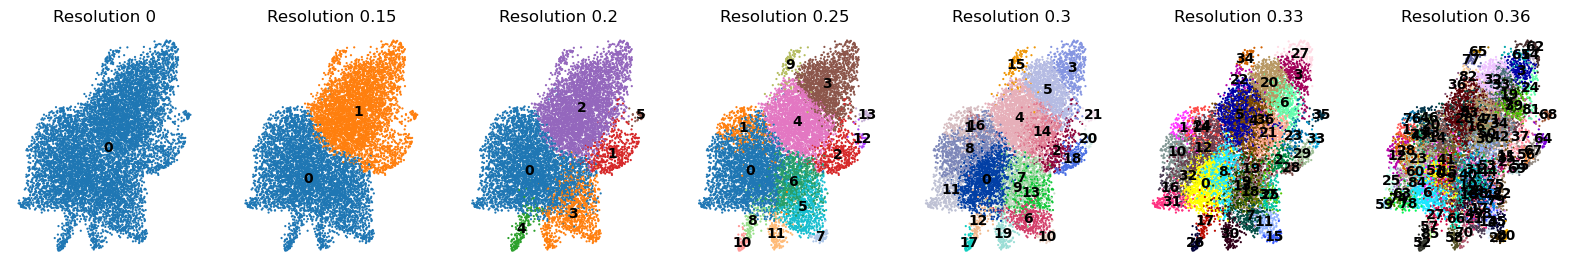

In [10]:
resolutions = [0, 0.15, 0.2, 0.25, 0.30, 0.33, 0.36]

# Create a figure with subplots
fig, axes = plt.subplots(1, 7, figsize=(20, 3))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot UMAP for each resolution
for ax, res in zip(axes, resolutions):
    sc.pl.umap(
        adata_harm_agg,
        color=f"leiden_{res}",
        size=10,
        projection="2d",
        cmap="hsv",
        legend_loc="on data",
        ax=ax,
        show=False,
    )

    # Rasterize the scatter plot
    for artist in ax.get_children():
        if isinstance(artist, PathCollection):
            artist.set_rasterized(True)

    # Remove the frame and axis labels
    ax.set_frame_on(False)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Set custom title
    ax.set_title(f"Resolution {res}")

# Remove any unused subplots
for i in range(len(resolutions), len(axes)):
    fig.delaxes(axes[i])

# Save the figure as SVG
fig.savefig("umaps_leiden_subclustering.svg", format="svg", dpi=600)

plt.show()

# Create a hierachical tree from the clustering

From the hierarchical clustering we can now construct a hierarchical tree that starts with all proteins (cluster 0 at resulution 0) and then splits the proteins into finer and finer clusters with increasing resolution.

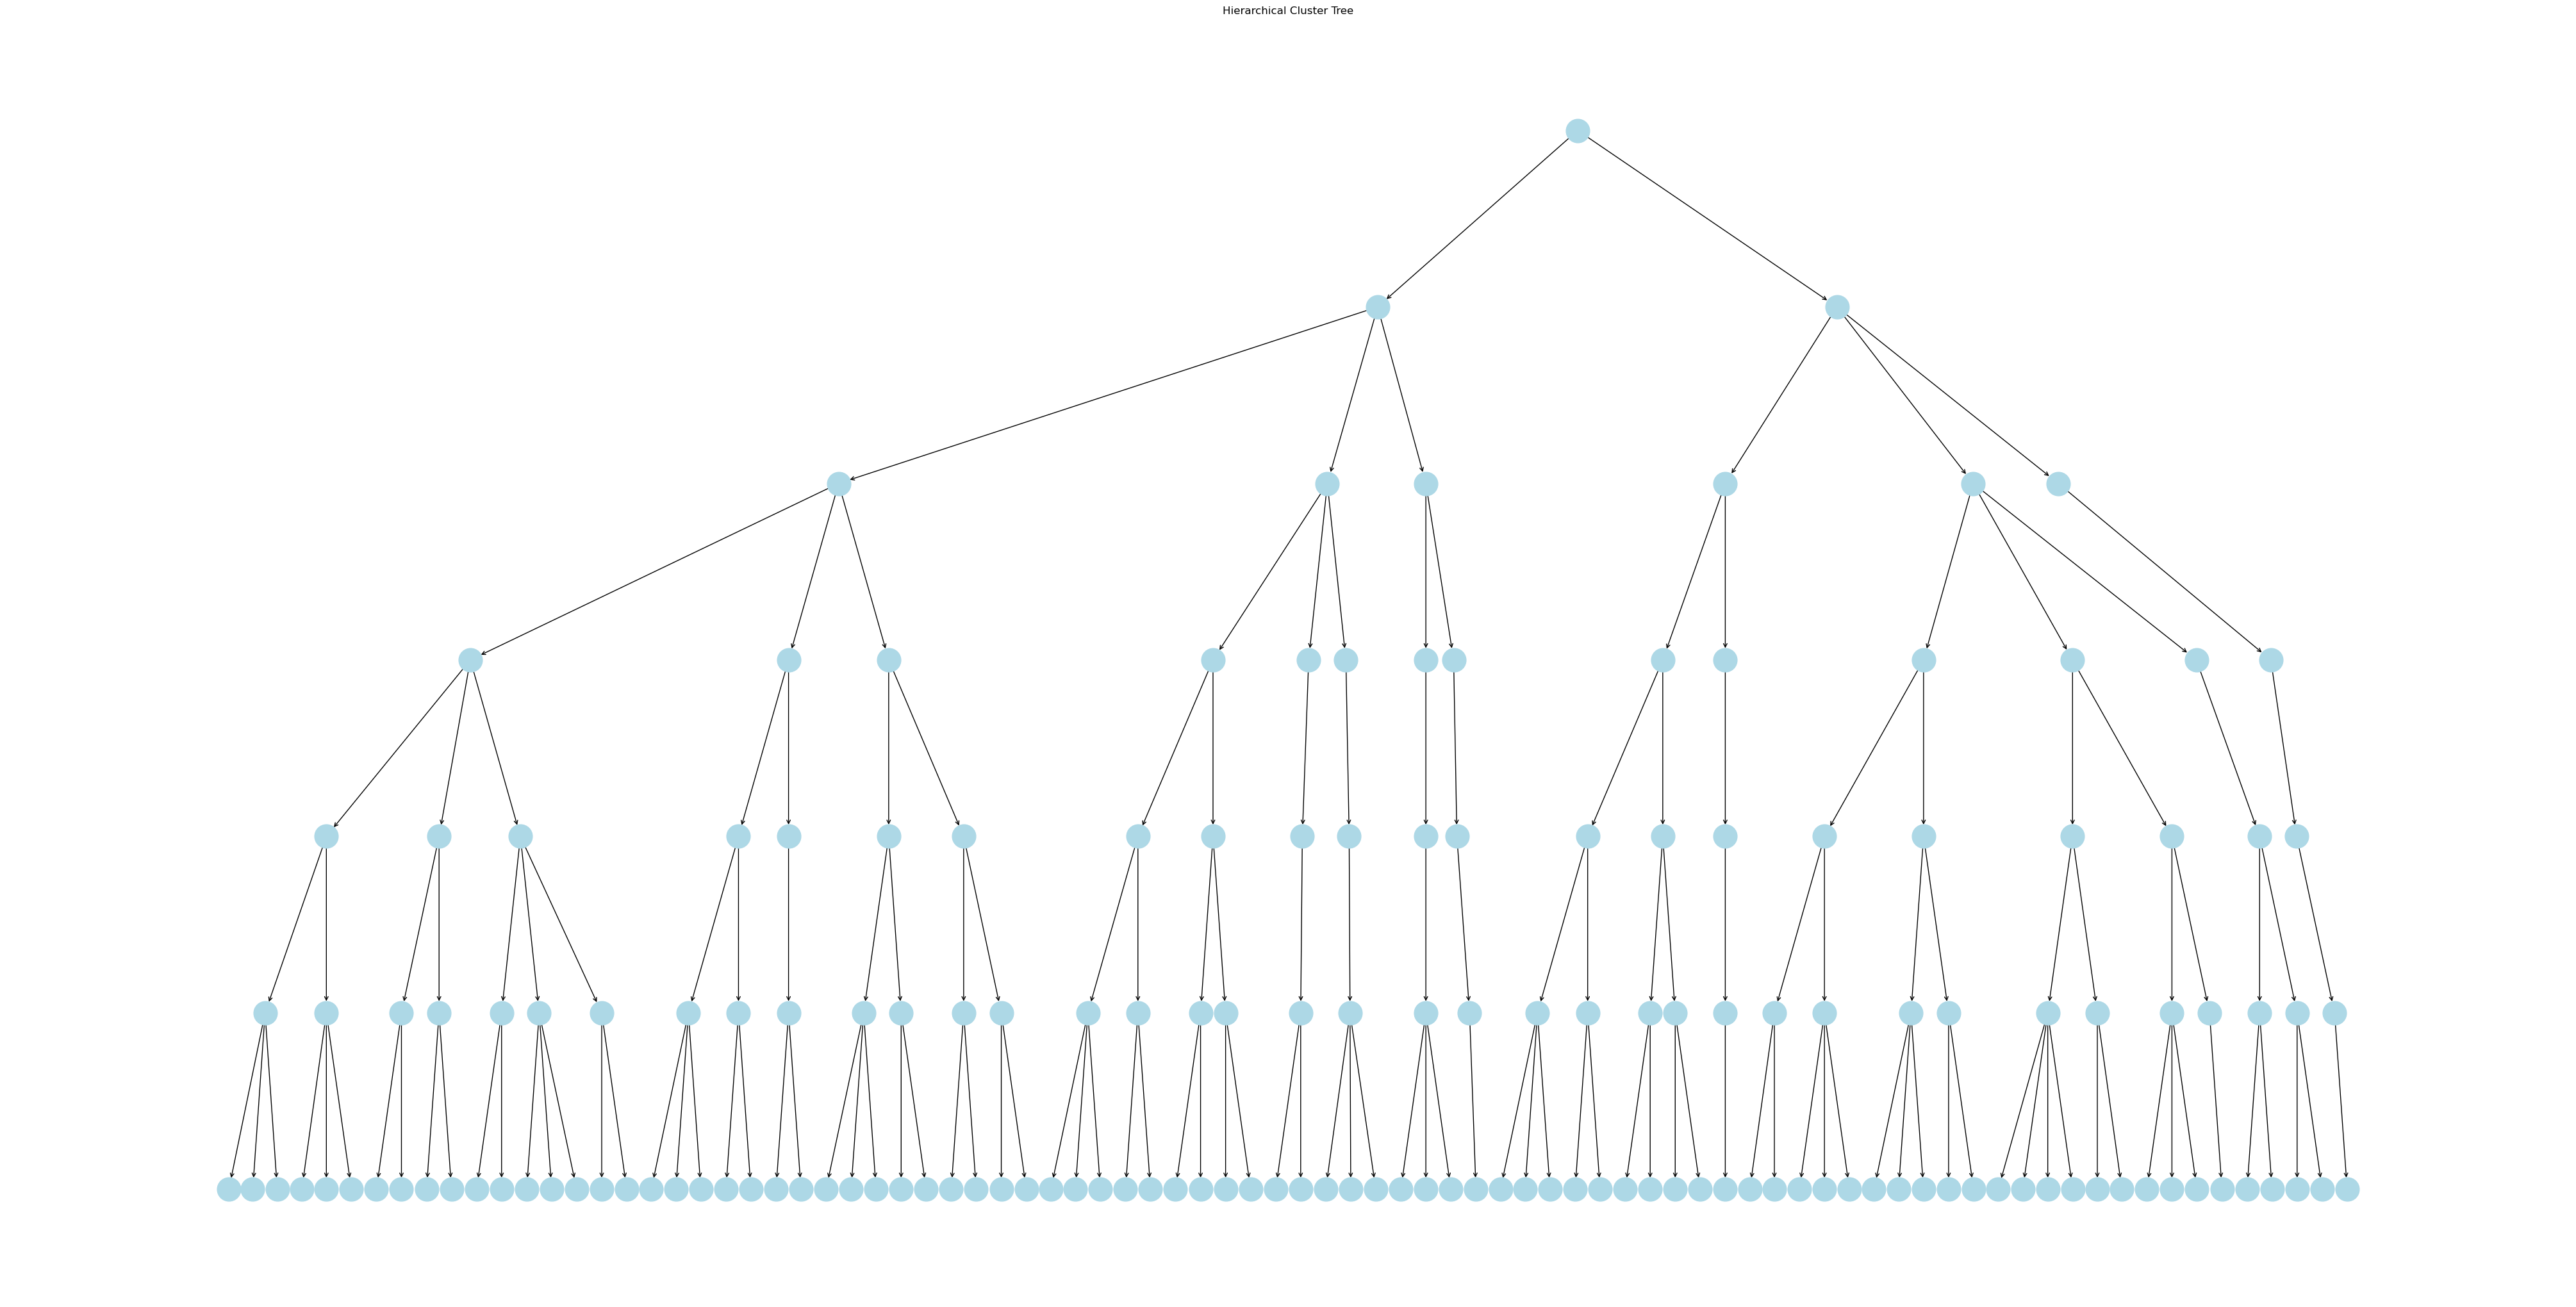

In [11]:
# Create a graph
G = nx.DiGraph()

# Step 1: Identify clusters and genes within each cluster for each resolution
clusters_genes = {}
for res in resolutions:
    clusters_genes[res] = {}
    for cluster in adata_harm_agg.obs[f"leiden_{res}"].unique():
        clusters_genes[res][cluster] = set(
            adata_harm_agg[adata_harm_agg.obs[f"leiden_{res}"] == cluster].obs[
                "gene_names"
            ]
        )

# Step 2: Create nodes for the graph
for res in resolutions:
    for cluster in clusters_genes[res]:
        G.add_node((res, cluster), genes=clusters_genes[res][cluster])

# Step 3: Create edges between nodes
for i in range(len(resolutions) - 1):
    res_i = resolutions[i]
    res_j = resolutions[i + 1]
    for cluster_i in clusters_genes[res_i]:
        genes_i = clusters_genes[res_i][cluster_i]
        for cluster_j in clusters_genes[res_j]:
            genes_j = clusters_genes[res_j][cluster_j]
            if len(genes_j.intersection(genes_i)) / len(genes_j) > 0.1:
                G.add_edge((res_i, cluster_i), (res_j, cluster_j))


# Step 4: Visualize the graph
# Use Graphviz layout for hierarchical tree layout
pos = nx.nx_agraph.graphviz_layout(G, prog="dot", args="-Grankdir=TB -Gnodesep=1")

# Plot the graph
plt.figure(figsize=(40, 20))
nx.draw(
    G,
    pos,
    with_labels=False,
    arrows=True,
    node_size=700,
    node_color="lightblue",
    arrowstyle="->",
)

plt.title("Hierarchical Cluster Tree")
plt.axis("off")
plt.show()

## Functional enrichment of the clusters/nodes

To evaluate the subcellular location and function of the proteins in the different clusters at different resolutions, we now run a functional enrichment analysis for each node in the tree. From level 2-6 we will determine significanlty enriched GO Cellular Component terms, and for level 7 (the highest resolution), we will test for significantly enriched GO Biological Process and GO Molecular Function term.

In [12]:
# Perform functional enrichment analysis for each node
gp = GProfiler(return_dataframe=True)
enrich_results = {}
for node in G.nodes:
    res, cluster = node
    cluster_indices = np.where(adata_harm_agg.obs[f"leiden_{res}"] == cluster)[0]
    protein_names = list(set(adata_harm_agg.obs["gene_names"].iloc[cluster_indices]))

    if len(protein_names) < 5:
        enrich_results[node] = None
    elif res == 0:
        enrich_results[node] = None
    else:
        if res == resolutions[-1]:
            # enrich_results[node] = None
            # continue
            result = gp.profile(
                organism="hsapiens",
                query=protein_names,
                sources=["GO:MF", "GO:BP"],
                no_evidences=False,
                user_threshold=0.05,
            )
        else:
            result = gp.profile(
                organism="hsapiens",
                query=protein_names,
                sources=["GO:CC"],
                no_evidences=False,
                user_threshold=0.05,
            )
        enrich_results[node] = result

# Visualize the functional enrichment anlysis results on the hierarchical tree

We now select the most significantly enriched GO term for each node as the label for the node. Additionally, we map the color of the node to the -log10(p value) of the term (clipped at 50) and the node size to the number of proteins included in the cluster.

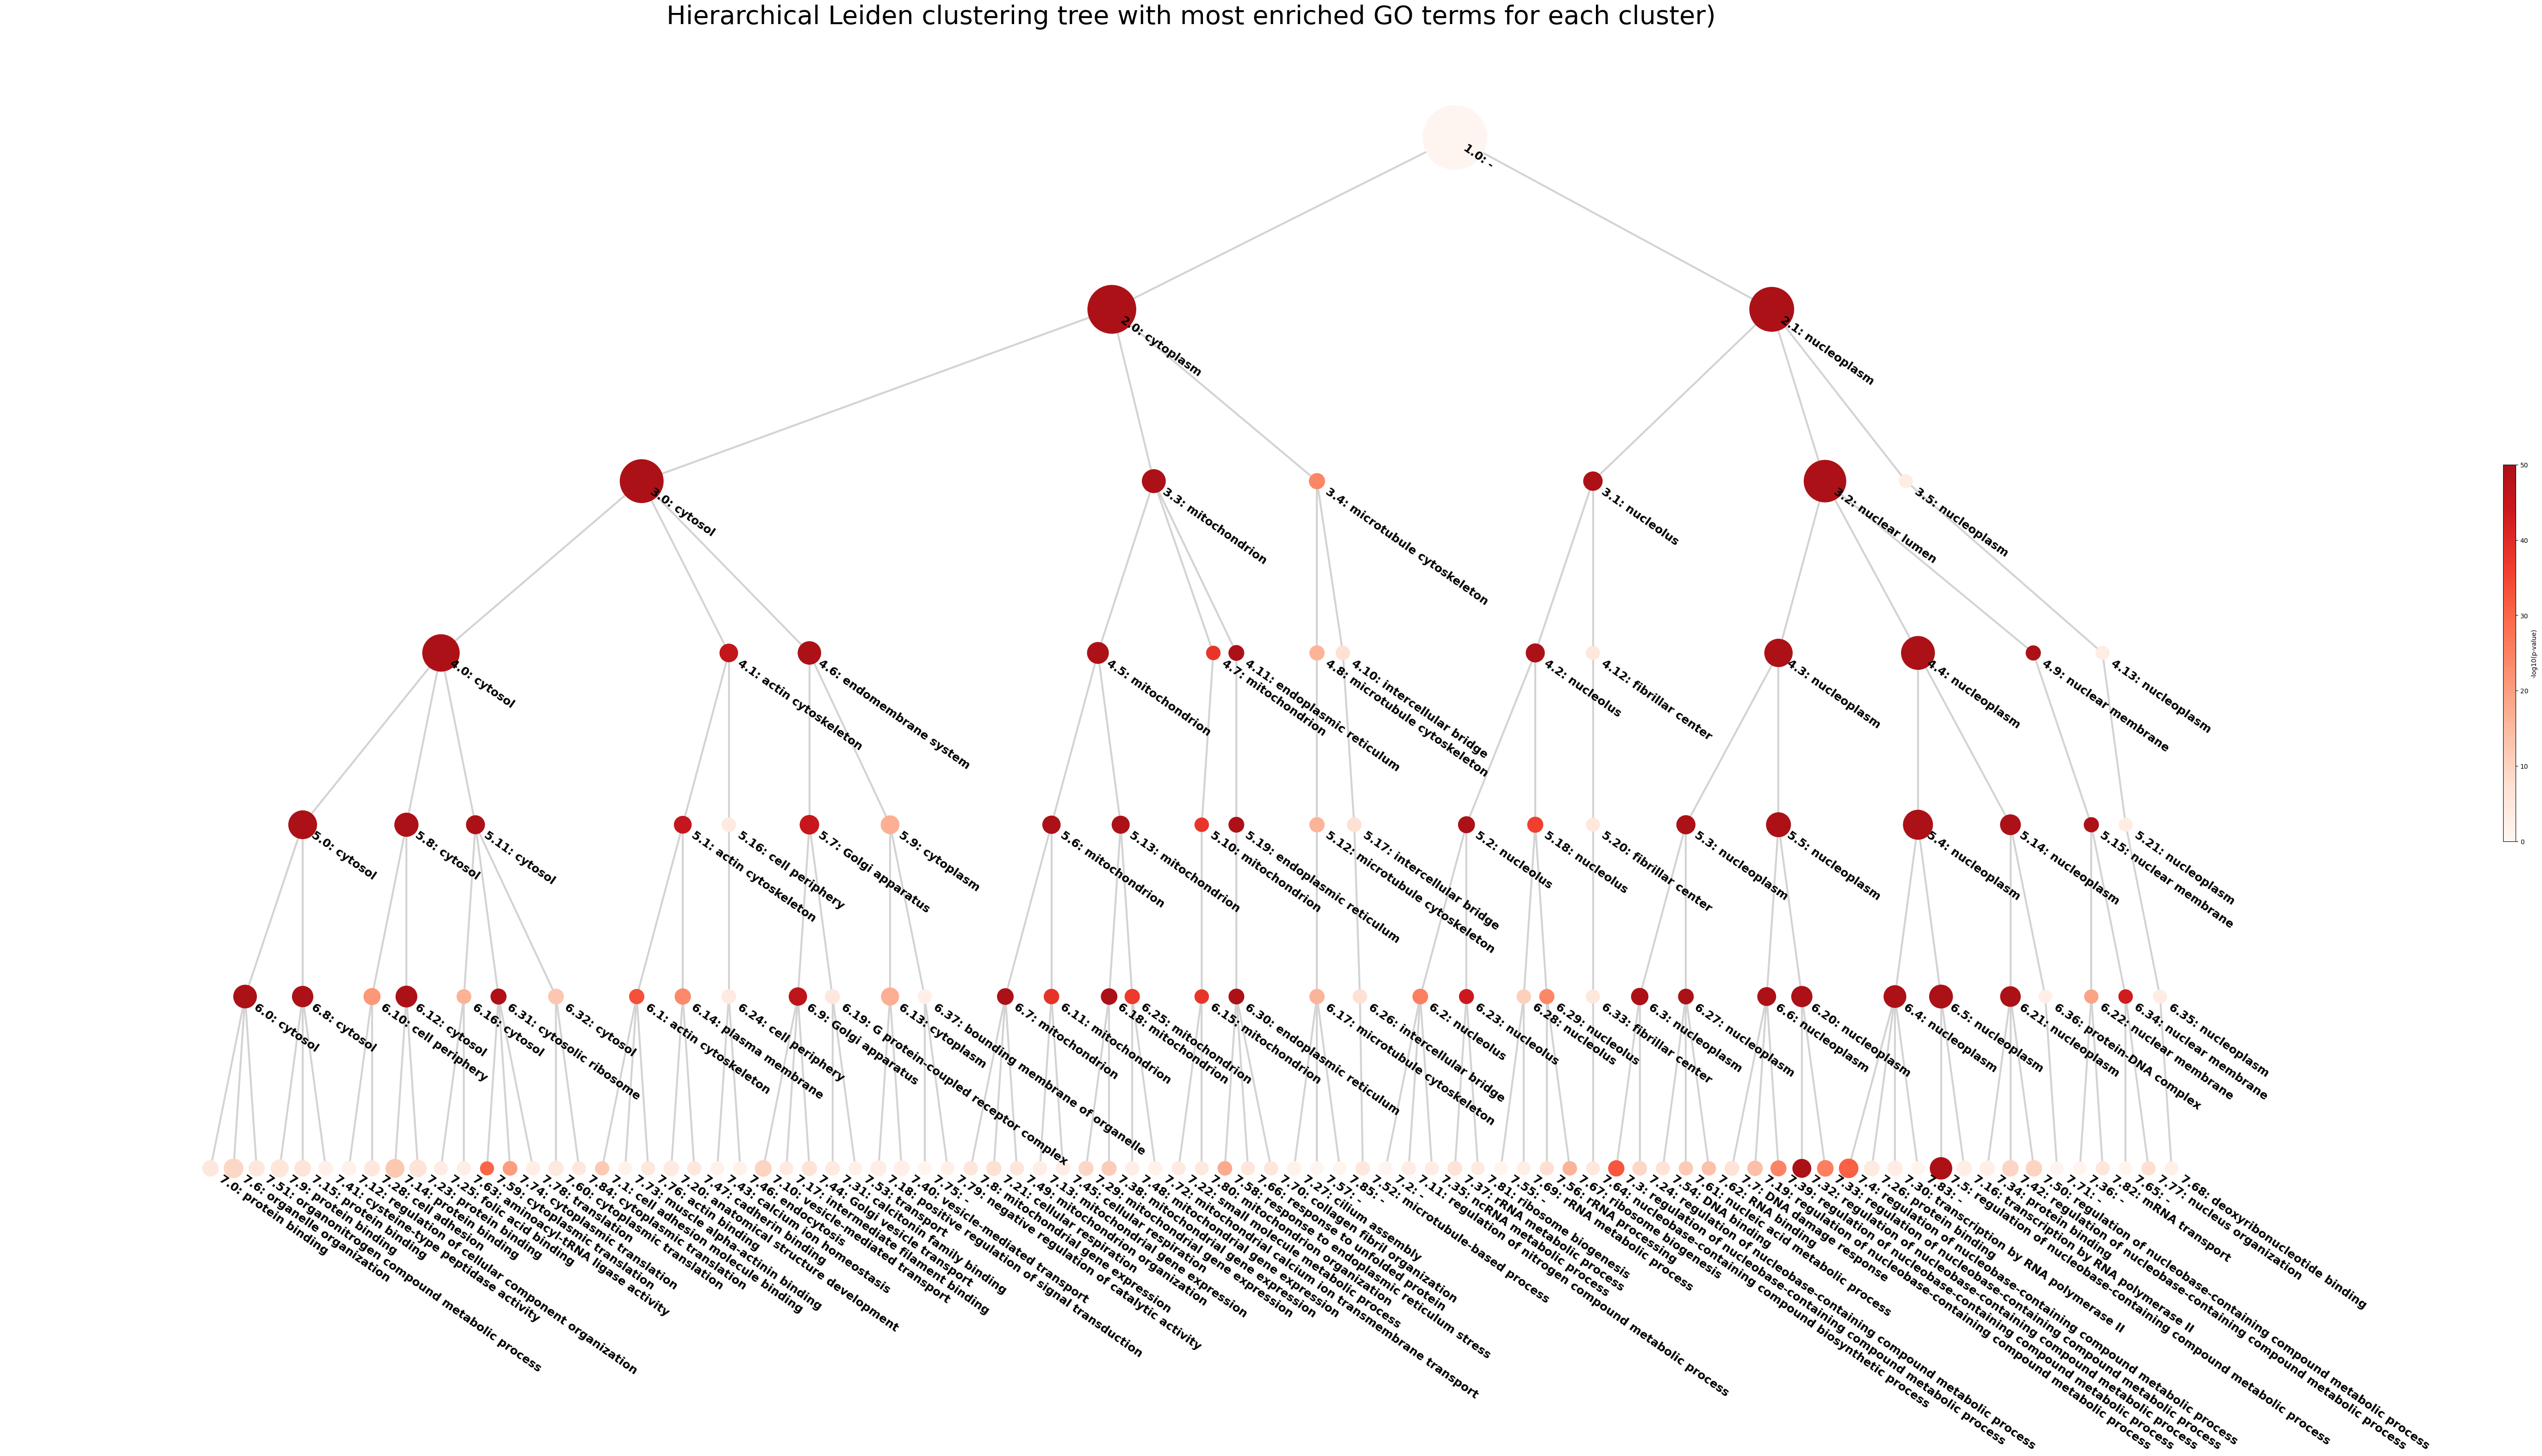

In [13]:
# Adjust the Reds colormap to remove the last 15% of the colors
cmap = plt.get_cmap("Reds")
truncated_cmap = mcolors.LinearSegmentedColormap.from_list(
    "truncated_reds", cmap(np.linspace(0, 0.85, 256))
)

# Create node labels based on the most significant term and calculate node size and color
level_dict = {0: 1, 0.15: 2, 0.2: 3, 0.25: 4, 0.3: 5, 0.33: 6, 0.36: 7}

node_sizes = []
node_colors = []
label_dict = {}

# Iterate over each node in the graph
for node in G.nodes:
    # Calculate node size based on the number of genes
    num_genes = len(G.nodes[node]["genes"])
    node_sizes.append(400 + num_genes)  # Scale the size for better visualization
    cluster = f"{node[1]}"
    level = level_dict[node[0]]

    # Check if there are enrichment results for the node
    if enrich_results[node] is not None and not enrich_results[node].empty:
        most_significant_term = enrich_results[node].iloc[0]

        # Create a label for the node based on the most significant term
        label_dict[node] = (
            f"{most_significant_term['name']} ({most_significant_term['native']})"
        )
        label = f"  {level}.{cluster}: {most_significant_term['name']}"
        p_value = most_significant_term["p_value"]

        # Calculate node color based on the -log10(p-value)
        node_colors.append((-np.log10(p_value)).clip(0, 50))

    else:
        # If no enrichment, set a default label and color
        label = f"  {level}.{cluster}: -"
        node_colors.append(0)  # No enrichment, set color to 0

    # Set the label for the node
    G.nodes[node]["label"] = label

# Visualize the graph with labels rotated by 45 degrees, node sizes, and colors
# Use Graphviz layout for hierarchical tree layout
pos = nx.nx_agraph.graphviz_layout(
    G, prog="dot", args="-Grankdir=TB -Gnodesep=300 -Granksep=3000"
)

# Manually adjust positions of specific nodes for better visualization
node_to_move = (0.15, "0")
pos[node_to_move] = (pos[node_to_move][0] * 0.85, pos[node_to_move][1])

node_to_move = (0.15, "1")
pos[node_to_move] = (pos[node_to_move][0] * 1.05, pos[node_to_move][1])

node_to_move = (0.2, "0")
pos[node_to_move] = (pos[node_to_move][0] * 0.78, pos[node_to_move][1])

node_to_move = (0.2, "3")
pos[node_to_move] = (pos[node_to_move][0] * 0.93, pos[node_to_move][1])

node_to_move = (0.25, "5")
pos[node_to_move] = (pos[node_to_move][0] * 0.975, pos[node_to_move][1])

# Create a figure for the plot
plt.figure(figsize=(70, 35))

# Draw the nodes with specified sizes and colors
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=truncated_cmap
)

# Draw the edges with a light gray color
edges = nx.draw_networkx_edges(G, pos, edge_color="#D3D3D3", width=3, arrows=False)

# Get the labels for the nodes
labels = nx.get_node_attributes(G, "label")

# Add text labels to the nodes
for key, (x, y) in pos.items():
    plt.text(
        x,
        y,
        labels[key],
        fontsize=18,
        fontweight="bold",
        ha="left",
        va="top",
        rotation=-35,
    )

# Add a colorbar to the plot
plt.colorbar(
    nodes, label="-log10(p-value)", fraction=0.005, location="right", aspect=30
)

# Add a title to the plot
plt.title(
    "Hierarchical Leiden clustering tree with most enriched GO terms for each cluster)",
    fontsize=40,
)

# Remove the axis frame
plt.axis("off")

# Save the plot as an SVG file
plt.savefig(
    "subcell_mae_u2os_subclustering_hierarchy_graph.svg",
    format="svg",
    bbox_inches="tight",
)

# Display the plot
plt.show()

## Save .obs as tsv file

Finally, we'll add the GO term labels of the nodes to the meta data dataframe and save it as tsv file.

In [14]:
# add go term labels for each level to obs
# Iterate over each resolution in level_dict
for resolution, level in level_dict.items():
    col_name = f"GO_term_level_{level}"
    leiden_col = f"leiden_{resolution}"

    # Map the cluster numbers to GO terms
    adata_harm_agg.obs[col_name] = (
        adata_harm_agg.obs[leiden_col]
        .astype(str)
        .map(lambda x: label_dict.get((resolution, x), "None"))
    )


# rename leiden columns to Cluster_level_{level}
for resolution, level in level_dict.items():
    leiden_col = f"leiden_{resolution}"
    adata_harm_agg.obs.rename(
        columns={leiden_col: f"Cluster_level_{level}"}, inplace=True
    )

adata_harm_agg.obs

,atlas_name_ensembl_ids,cell_id,if_plate_id,position,sample,atlas_name,antibody,ensembl_ids,gene_names,cell_path,...,Cluster_level_5,Cluster_level_6,Cluster_level_7,GO_term_level_1,GO_term_level_2,GO_term_level_3,GO_term_level_4,GO_term_level_5,GO_term_level_6,GO_term_level_7
0,U2OS_ENSG00000000003,1,23,H11,1,U2OS,HPA004109,ENSG00000000003,TSPAN6,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,...,0,0,0,None,cytoplasm (GO:0005737),cytosol (GO:0005829),cytosol (GO:0005829),cytosol (GO:0005829),cytosol (GO:0005829),protein binding (GO:0005515)
1,U2OS_ENSG00000000938,1,59,H5,1,U2OS,HPA002024,ENSG00000000938,FGR,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,...,1,1,1,None,cytoplasm (GO:0005737),cytosol (GO:0005829),actin cytoskeleton (GO:0015629),actin cytoskeleton (GO:0015629),actin cytoskeleton (GO:0015629),cell adhesion molecule binding (GO:0050839)
2,U2OS_ENSG00000001084,1,931,H5,3,U2OS,CAB009569,ENSG00000001084,GCLC,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,...,2,2,2,None,nucleoplasm (GO:0005654),nucleolus (GO:0005730),nucleolus (GO:0005730),nucleolus (GO:0005730),nucleolus (GO:0005730),None
3,U2OS_ENSG00000001167,1,835,D10,1,U2OS,HPA050779,ENSG00000001167,NFYA,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,...,3,3,3,None,nucleoplasm (GO:0005654),nuclear lumen (GO:0031981),nucleoplasm (GO:0005654),nucleoplasm (GO:0005654),nucleoplasm (GO:0005654),regulation of nucleobase-containing compound m...
4,U2OS_ENSG00000001460,1,226,A6,1,U2OS,HPA024301,ENSG00000001460,STPG1,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,...,4,4,4,None,nucleoplasm (GO:0005654),nuclear lumen (GO:0031981),nucleoplasm (GO:0005654),nucleoplasm (GO:0005654),nucleoplasm (GO:0005654),regulation of nucleobase-containing compound m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9538,U2OS_ENSG00000284308,1,1055,B2,1,U2OS,HPA049564,ENSG00000284308,C2orf81,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,...,18,29,56,None,nucleoplasm (GO:0005654),nucleolus (GO:0005730),nucleolus (GO:0005730),nucleolus (GO:0005730),nucleolus (GO:0005730),rRNA processing (GO:0006364)
9539,U2OS_ENSG00000286140,1,760,E12,1,U2OS,HPA051872,ENSG00000286140,DERPC,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,...,5,20,33,None,nucleoplasm (GO:0005654),nuclear lumen (GO:0031981),nucleoplasm (GO:0005654),nucleoplasm (GO:0005654),nucleoplasm (GO:0005654),regulation of nucleobase-containing compound m...
9540,U2OS_ENSG00000288701,1,1132,B12,1,U2OS,HPA064301,ENSG00000288701,PRRC2B,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,...,0,8,41,None,cytoplasm (GO:0005737),cytosol (GO:0005829),cytosol (GO:0005829),cytosol (GO:0005829),cytosol (GO:0005829),cysteine-type peptidase activity (GO:0008234)
9541,U2OS_ENSG00000290292,1,603,F6,2,U2OS,HPA036316,ENSG00000290292,HOMEZ,/mnt/workdisk/subcell-embed/data/hpa_data/crop...,...,2,23,37,None,nucleoplasm (GO:0005654),nucleolus (GO:0005730),nucleolus (GO:0005730),nucleolus (GO:0005730),nucleolus (GO:0005730),rRNA metabolic process (GO:0016072)


In [15]:
# save obs to csv file
adata_harm_agg.obs.to_csv("subcell_mae_u2os_clustered_GO_terms.tsv", sep="\t")

## Export notebook as html file

In [16]:
import os

os.system(
    "jupyter nbconvert --to html MAE_HPA_U2OS_embedding_subclustering_and_ORA.ipynb"
)

[NbConvertApp] Converting notebook MAE_HPA_U2OS_embedding_subclustering_and_ORA.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 3996954 bytes to MAE_HPA_U2OS_embedding_subclustering_and_ORA.html


0